/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv



In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Set random seed for reproducibility
np.random.seed(42)

# Setup path
TRAIN_PATH = '/kaggle/input/titanic/train.csv'
TEST_PATH = '/kaggle/input/titanic/test.csv'
OUTPUT_PATH = '/kaggle/working/gender_submission.csv'
BEST_MODEL_PATH = '/kaggle/working/best_model.pth'
print(os.listdir('/kaggle/input/titanic'))

['train.csv', 'test.csv', 'gender_submission.csv']


In [2]:
# Visualize data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
print("Train data:")
print(train_df.head())
print('\n\n')
print("Test data:")
print(test_df.head())

Train data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

In [3]:
# Preprocess data

#Transform survived to boolean
train_df['Survived'] = train_df['Survived'].astype(bool)

# Get target variable
y = train_df['Survived']

X = train_df
X_test = test_df

# Fill missing values
X['Age'] = X['Age'].fillna(X['Age'].mean())
X['Fare'] = X['Fare'].fillna(X['Fare'].mean())
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())

# Create pertinent features
# Family size
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1
#Solo, duo, one child, two children, three children, big family
X['FamilySizeGroup'] = pd.cut(X['FamilySize'], bins=[0, 1, 2, 3, 4, 5, 30], labels=['Solo', 'Duo', 'OneChild', 'TwoChildren', 'ThreeChildren', 'BigFamily'])
X_test['FamilySizeGroup'] = pd.cut(X_test['FamilySize'], bins=[0, 1, 2, 3, 4, 5, 30], labels=['Solo', 'Duo', 'OneChild', 'TwoChildren', 'ThreeChildren', 'BigFamily'])
# Split Pclass into 3 categories
X['Pclass'] = X['Pclass'].astype(str)
X_test['Pclass'] = X_test['Pclass'].astype(str)
# Split SibSp into 4 categories
X['SibSp'] = X['SibSp'].astype(str)
X_test['SibSp'] = X_test['SibSp'].astype(str)
# Split Parch into 4 categories
X['Parch'] = X['Parch'].astype(str)
X_test['Parch'] = X_test['Parch'].astype(str)
# IsAlone
X['IsAlone'] = (X['FamilySize'] == 1)
X_test['IsAlone'] = (X_test['FamilySize'] == 1)
# Age group
X['AgeGroup'] = pd.cut(X['Age'], bins=[0, 12, 21, 65, 200], labels=['Childrens', 'Adolescents', 'Adults', 'Seniors'])
X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=[0, 12, 18, 65, 200], labels=['Childrens', 'Adolescents', 'Adults', 'Seniors'])
# Fare group
X['FareGroup'] = pd.cut(X['Fare'], bins=[-1, 6, 12, 29, 870, 10000], labels=['Low_fare', 'Medium_fare', 'High_fare', 'Very_high_fare', 'Ultra_high_fare'])
X_test['FareGroup'] = pd.cut(X_test['Fare'], bins=[-1, 6, 12, 29, 870, 10000], labels=['Low_fare', 'Medium_fare', 'High_fare', 'Very_high_fare', 'Ultra_high_fare'])
# Title
X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X['Title'] = X['Title'].replace('Mlle', 'Miss')
X['Title'] = X['Title'].replace('Ms', 'Miss')
X['Title'] = X['Title'].replace('Mme', 'Mrs')
X_test['Title'] = X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['Title'] = X_test['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X_test['Title'] = X_test['Title'].replace('Mlle', 'Miss')
X_test['Title'] = X_test['Title'].replace('Ms', 'Miss')
X_test['Title'] = X_test['Title'].replace('Mme', 'Mrs')

# Get rid of unnecessary columns
X = X.drop(['Age', 'Fare', 'Name', 'Ticket', 'Cabin', 'PassengerId', 'FamilySize'], axis=1) 
X_test = X_test.drop(['Age', 'Fare', 'Name', 'Ticket', 'Cabin', 'PassengerId', 'FamilySize'], axis=1)

print(X.head())

   Survived Pclass     Sex SibSp Parch Embarked FamilySizeGroup  IsAlone  \
0     False      3    male     1     0        S             Duo    False   
1      True      1  female     1     0        C             Duo    False   
2      True      3  female     0     0        S            Solo     True   
3      True      1  female     1     0        S             Duo    False   
4     False      3    male     0     0        S            Solo     True   

  AgeGroup       FareGroup Title  
0   Adults     Medium_fare    Mr  
1   Adults  Very_high_fare   Mrs  
2   Adults     Medium_fare  Miss  
3   Adults  Very_high_fare   Mrs  
4   Adults     Medium_fare    Mr  


In [4]:
# One-hot encode categorical variables
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

# Make sure there are no missing values and all values are numerical
print("Train data:")
print(X.info())
print('\n\n')
print("Test data:")
print(X_test.info())

# Make sure there are no empty / NaN values
print("Train data:")
print(X.isnull().sum())
print('\n\n')
print("Test data:")
print(X_test.isnull().sum())

# Show head of data
print("Train data:")
print(X.head())
print('\n\n')
print("Test data:")
print(X_test.head())


# Number of features
input_dim = X.shape[1]
print("Input dimensions: %s" % (input_dim))

Train data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Survived                       891 non-null    bool 
 1   IsAlone                        891 non-null    bool 
 2   Pclass_1                       891 non-null    bool 
 3   Pclass_2                       891 non-null    bool 
 4   Pclass_3                       891 non-null    bool 
 5   Sex_female                     891 non-null    bool 
 6   Sex_male                       891 non-null    bool 
 7   SibSp_0                        891 non-null    bool 
 8   SibSp_1                        891 non-null    bool 
 9   SibSp_2                        891 non-null    bool 
 10  SibSp_3                        891 non-null    bool 
 11  SibSp_4                        891 non-null    bool 
 12  SibSp_5                        891 non-null    bool 
 13  SibSp_8 

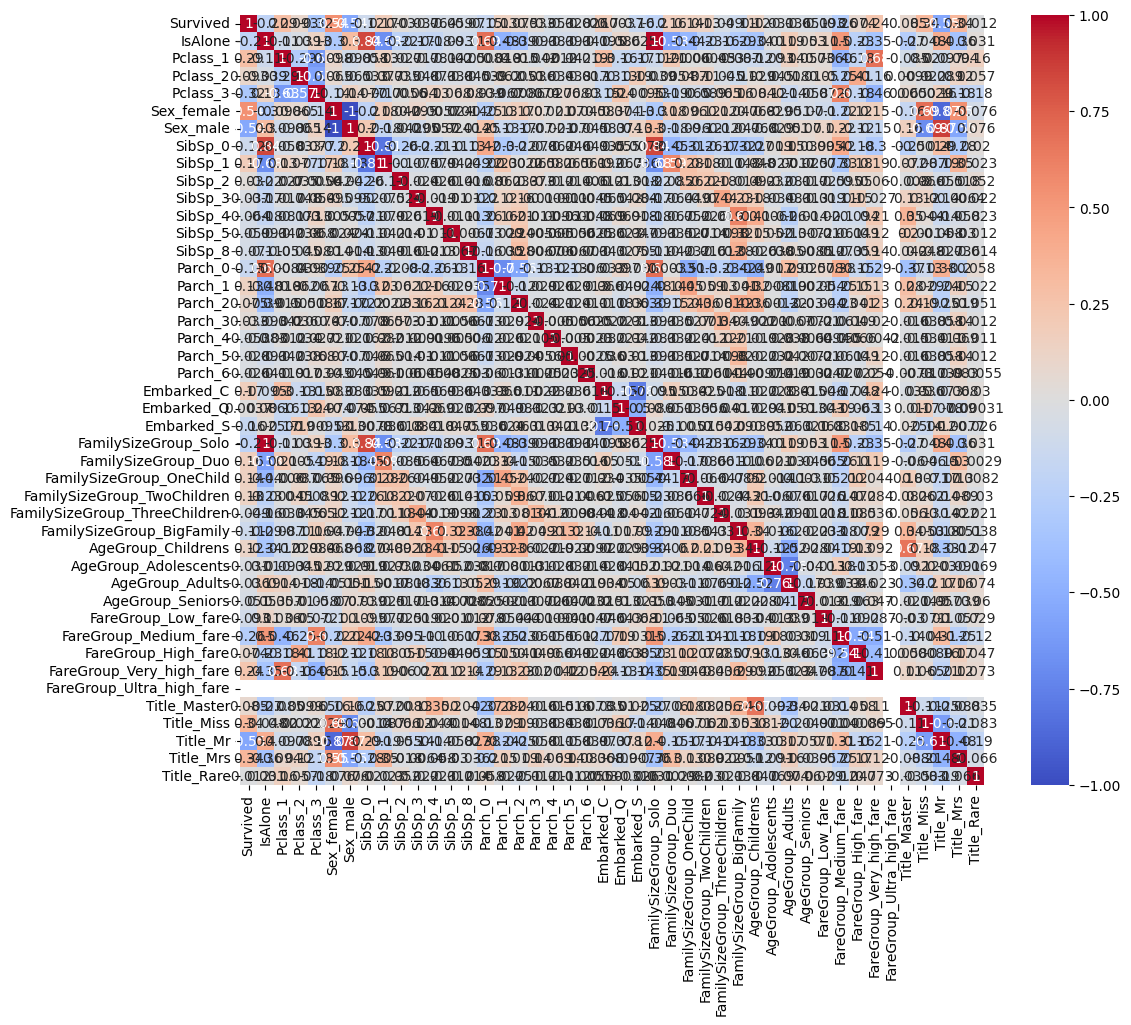

In [5]:
# Generate heatmap using seaborn
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [6]:
# Split data for training and validation, in order for the MLP to be able to generalize well
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset for boolean classification (all inputs are boolean)

class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.bool)
        self.y = torch.tensor(y.values, dtype=torch.bool).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TitanicDataset(X_train, y_train)
val_dataset = TitanicDataset(X_val, y_val)

print("Dataset generated")

Dataset generated


In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.5)  # Add dropout layer
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(0.5)  # Add dropout layer
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize model
model = MLP(input_dim)
print(model)

MLP(
  (fc1): Linear(in_features=44, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [8]:

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(criterion)

BCELoss()


In [9]:
# Train model (print loss and accuracy for both training and validation sets)

n_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')  # Initialize with a high value

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    correct = 0
    for X_batch, y_batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        optimizer.zero_grad()
        output = model(X_batch.float())
        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += sum((output > 0.5) == y_batch)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    train_acc = correct / len(train_dataset)
    train_accs.append(train_acc)
    
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in DataLoader(val_dataset, batch_size=16):
            output = model(X_batch.float())
            loss = criterion(output, y_batch.float())
            val_loss += loss.item()
            correct += sum((output > 0.5) == y_batch)
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    val_acc = correct / len(val_dataset)
    val_accs.append(val_acc)
    
    print("Epoch %d, train loss: %.4f, val loss: %.4f, train acc: %.4f, val acc: %.4f" % (epoch, train_loss, val_loss, train_acc, val_acc))
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("Best model saved at %s" % (BEST_MODEL_PATH))

Epoch 0, train loss: 0.0321, val loss: 0.0175, train acc: 0.7402, val acc: 0.8715
Best model saved at /kaggle/working/best_model.pth
Epoch 1, train loss: 0.0100, val loss: 0.0027, train acc: 0.9494, val acc: 1.0000
Best model saved at /kaggle/working/best_model.pth
Epoch 2, train loss: 0.0020, val loss: 0.0005, train acc: 0.9944, val acc: 1.0000
Best model saved at /kaggle/working/best_model.pth
Epoch 3, train loss: 0.0006, val loss: 0.0002, train acc: 0.9986, val acc: 1.0000
Best model saved at /kaggle/working/best_model.pth
Epoch 4, train loss: 0.0003, val loss: 0.0001, train acc: 1.0000, val acc: 1.0000
Best model saved at /kaggle/working/best_model.pth
Epoch 5, train loss: 0.0002, val loss: 0.0001, train acc: 1.0000, val acc: 1.0000
Best model saved at /kaggle/working/best_model.pth
Epoch 6, train loss: 0.0004, val loss: 0.0000, train acc: 0.9958, val acc: 1.0000
Best model saved at /kaggle/working/best_model.pth
Epoch 7, train loss: 0.0001, val loss: 0.0000, train acc: 1.0000, val

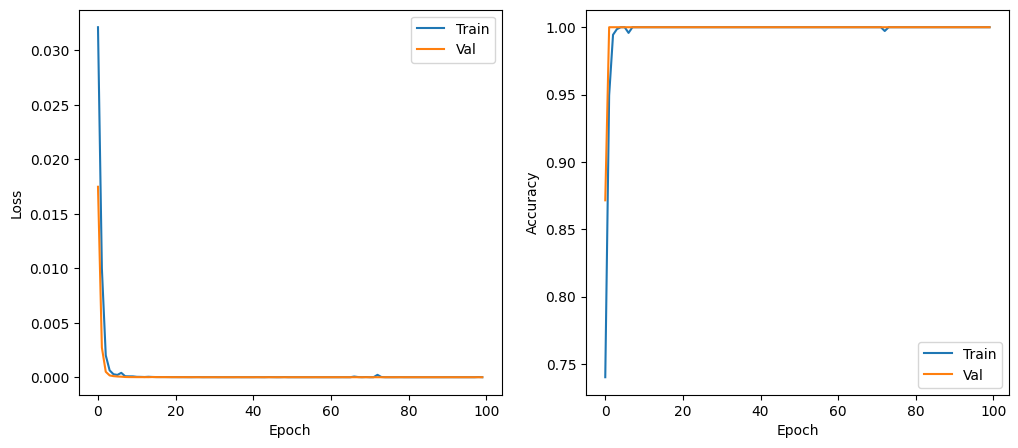

In [10]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Load best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# Test model
model.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_pred = model(X_test_tensor).detach().numpy().flatten()
y_pred = (y_pred > 0.5).astype(int)

# Save predictions
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': y_pred})
output.to_csv(OUTPUT_PATH, index=False)
print("Predictions saved at %s" % (OUTPUT_PATH))

Predictions saved at /kaggle/working/gender_submission.csv
